# Visualize

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def pad_image(data, padding):
    if len(data.shape) < 3:
        data = np.lib.pad(data, ((padding, padding), (padding, padding)), 'reflect')
    else:
        data = np.lib.pad(data, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h, stride, ext):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if not is_2d:
        im = np.lib.pad(im, ((ext, ext), (ext, ext), (0,0)), 'reflect')
    for i in range(ext,imgheight+ext,stride):
        for j in range(ext,imgwidth+ext,stride):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                #im_patch = im[j:j+w, i:i+h, :]
                im_patch = im[j-ext:j+w+ext, i-ext:i+h+ext, :]
            list_patches.append(im_patch)
    return list_patches

# Extract features for a given image
def extract_img_features(filename, stride):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size, stride, padding)
    X = np.asarray([img_patches[i] for i in range(len(img_patches))])
    return X

In [3]:
patch_size = 16
window_size = 72
padding = (window_size - patch_size) // 2
stride = 16

In [4]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels, stride):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [16]:
from CNNv2 import CNN
#%run ./CNN.ipynb
%run ./helpers.ipynb

In [17]:
model = CNN()
model.load('best_002.h5')

# Visualize

## subtest


In [18]:
def create_mask(path):
    img = mpimg.imread(path)

    img_c = np.zeros((4, 320, 320, 3))
    for i in range(4):
        img_c[i], _ = model.crop_corner(img, img, i)
    out = model.model.predict(img_c)
    
    ##reconstruct image which was 608 by 608 with images of size 320 by 320
    mask = np.zeros((608,608))
    mask[0:320, 0:320] = np.squeeze(out[0])
    mask[288:608, 0:320] = np.squeeze(out[2])
    mask[0:320, 288:608] = np.squeeze(out[1])
    mask[288:608, 288:608] = np.squeeze(out[3])
    return mask


In [20]:
model = CNN(rootdir='.', window_size=608)
model.load('best_002.h5')
test_dir = "test_set_images/test_"

def show_test():
    for i in range(1,2):
        direc = test_dir + str(i) + "/test_" + str(i) + ".png"
        out = create_mask(direc)
        plt.figure()
        plt.imshow(mpimg.imread(direc))
        plt.figure()
        plt.imshow(out)
        
#show_test()
        

In [37]:
def submission():
    submission_filename = 'submission.csv'
    image_filenames = []
    for i in range(1, 51):
        image_filename = 'test_set_images/test_'+str(i)+'/test_' + str(i) + '.png'
        image_filenames.append(image_filename)
        
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

    # assign a label to a patch
    def patch_to_label(patch):
        df = np.mean(patch)
        if df > foreground_threshold:
            return 1
        else:
            return 0
        
    def mask_to_submission_strings(model, image_filename):
        img_number = int(re.search(r"\d+", image_filename).group(0))
        input_image = np.expand_dims(mpimg.imread(image_filename), axis=0)
        print(input_image.shape)
        Xi = model.model.predict(input_image)
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(mpimg.imread(image_filename))
        axs[1].imshow(np.squeeze(Xi))
        patch_size = 16
        ground = Xi.copy()
        print("Processing " + image_filename)   
        for j in range(0, Xi.shape[1], patch_size):
            for i in range(0, Xi.shape[0], patch_size):
                patch = Xi[i:i + patch_size, j:j + patch_size]
                label = patch_to_label(patch)
                yield("{:03d}_{}_{},{}".format(img_number, j, i, label))
                
                ground[i:i + patch_size, j:j + patch_size].fill(label)
        axs[2].imshow(np.squeeze(ground[0]))
        
    def generate_submission(model, submission_filename, *image_filenames):
        """ Generate a .csv containing the classification of the test set. """
        with open(submission_filename, 'w') as f:
            f.write('id,prediction\n')
            for fn in image_filenames[0:]:
                f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(model, fn))
    generate_submission(model, submission_filename, *image_filenames)

(1, 608, 608, 3)
Processing test_set_images/test_1/test_1.png
(1, 608, 608, 3)
Processing test_set_images/test_2/test_2.png
(1, 608, 608, 3)
Processing test_set_images/test_3/test_3.png
(1, 608, 608, 3)
Processing test_set_images/test_4/test_4.png
(1, 608, 608, 3)
Processing test_set_images/test_5/test_5.png
(1, 608, 608, 3)
Processing test_set_images/test_6/test_6.png
(1, 608, 608, 3)
Processing test_set_images/test_7/test_7.png
(1, 608, 608, 3)
Processing test_set_images/test_8/test_8.png
(1, 608, 608, 3)
Processing test_set_images/test_9/test_9.png
(1, 608, 608, 3)
Processing test_set_images/test_10/test_10.png
(1, 608, 608, 3)
Processing test_set_images/test_11/test_11.png
(1, 608, 608, 3)
Processing test_set_images/test_12/test_12.png
(1, 608, 608, 3)
Processing test_set_images/test_13/test_13.png
(1, 608, 608, 3)
Processing test_set_images/test_14/test_14.png
(1, 608, 608, 3)
Processing test_set_images/test_15/test_15.png
(1, 608, 608, 3)
Processing test_set_images/test_16/test_1

C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Processing test_set_images/test_21/test_21.png
(1, 608, 608, 3)
Processing test_set_images/test_22/test_22.png
(1, 608, 608, 3)
Processing test_set_images/test_23/test_23.png
(1, 608, 608, 3)
Processing test_set_images/test_24/test_24.png
(1, 608, 608, 3)
Processing test_set_images/test_25/test_25.png
(1, 608, 608, 3)
Processing test_set_images/test_26/test_26.png
(1, 608, 608, 3)
Processing test_set_images/test_27/test_27.png
(1, 608, 608, 3)
Processing test_set_images/test_28/test_28.png
(1, 608, 608, 3)
Processing test_set_images/test_29/test_29.png
(1, 608, 608, 3)
Processing test_set_images/test_30/test_30.png
(1, 608, 608, 3)
Processing test_set_images/test_31/test_31.png
(1, 608, 608, 3)
Processing test_set_images/test_32/test_32.png
(1, 608, 608, 3)
Processing test_set_images/test_33/test_33.png
(1, 608, 608, 3)
Processing test_set_images/test_34/test_34.png
(1, 608, 608, 3)
Processing test_set_images/test_35/test_35.png
(1, 608, 608, 3)
Processing test_set_images/test_36/test_

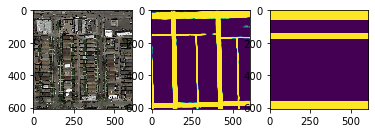

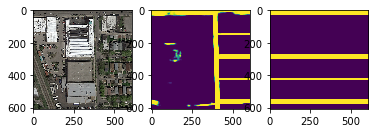

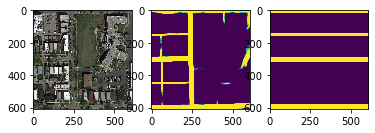

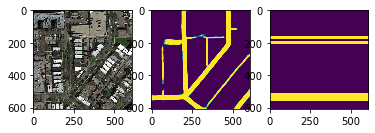

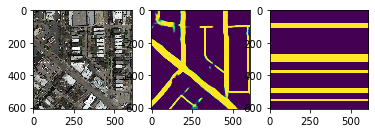

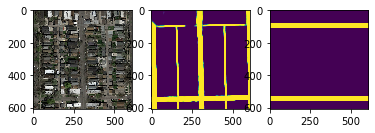

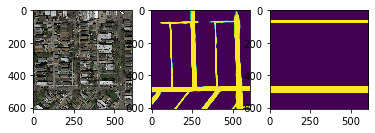

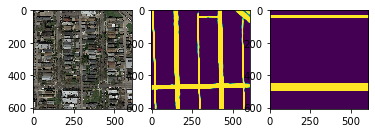

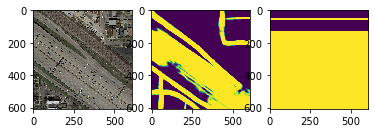

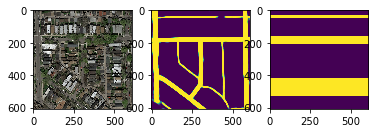

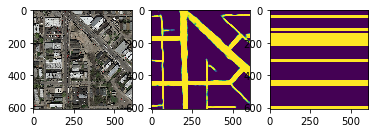

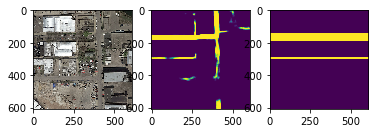

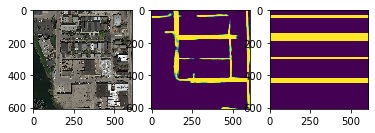

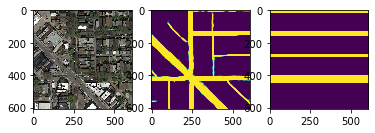

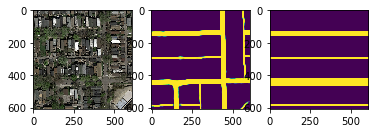

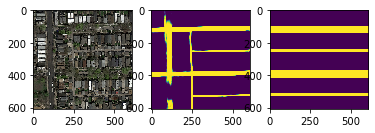

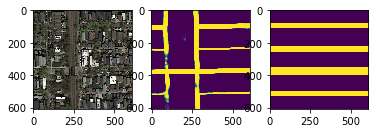

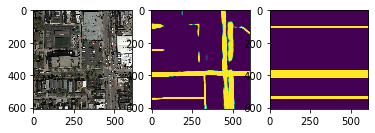

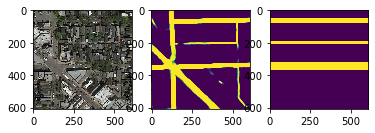

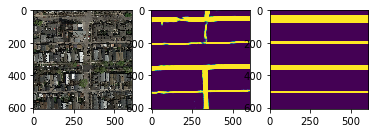

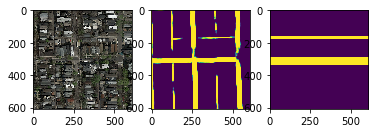

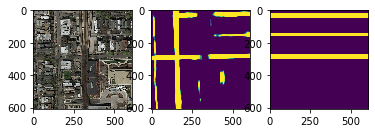

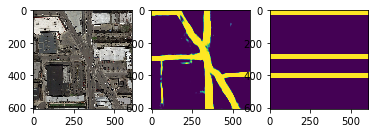

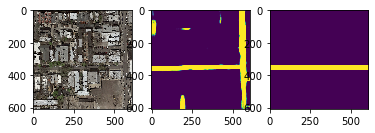

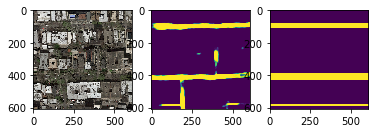

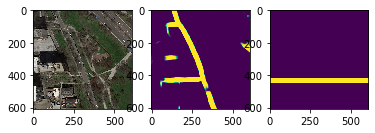

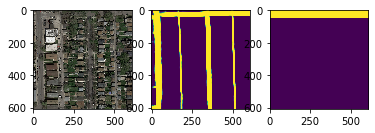

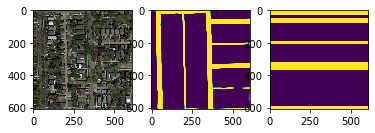

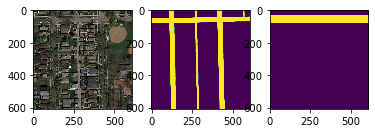

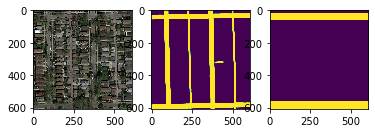

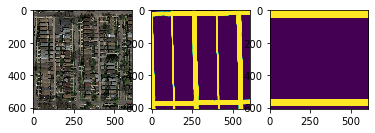

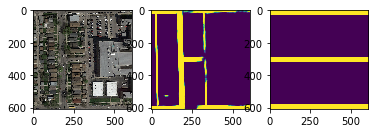

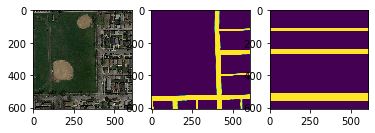

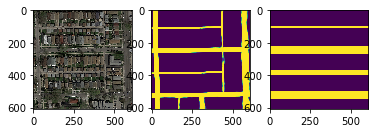

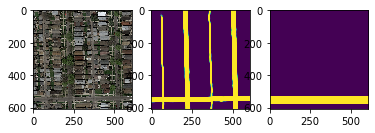

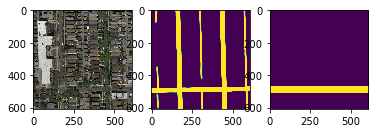

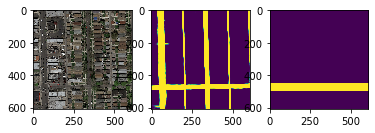

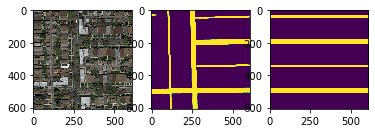

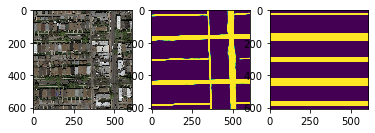

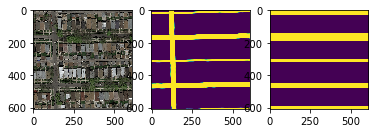

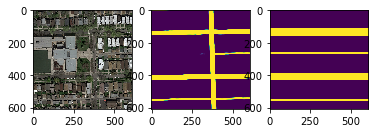

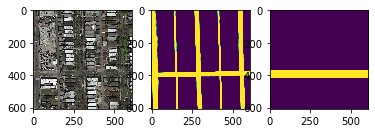

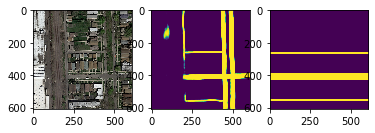

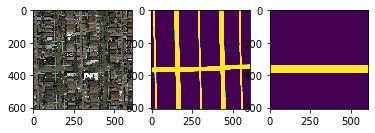

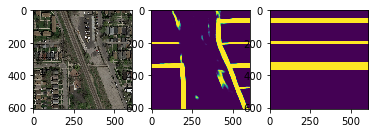

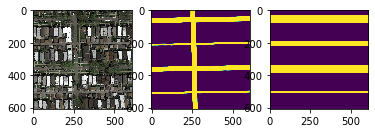

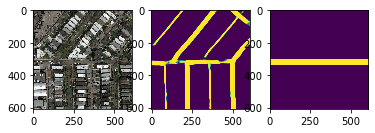

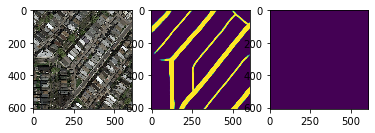

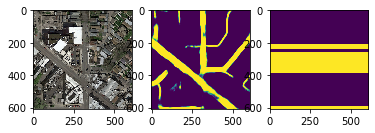

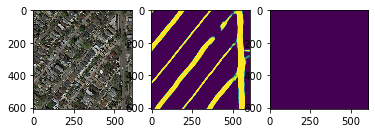

In [38]:
submission()

## end subtest

In [ ]:
test_dir = "test_set_images/test_"
direc = test_dir + str(1) + "/test_" + str(1) + ".png"
plt.figure()
plt.imshow(mpimg.imread(direc))
l = mpimg.imread(direc)
img, _ = my_crop_corner(l, l, corner=3)
plt.figure()
plt.imshow(np.squeeze(img))

img = np.expand_dims(img, axis=0)
out = model.model.predict(img)
out = np.squeeze(out)
plt.figure()
plt.imshow(out)

In [ ]:
# Run prediction on the img_idx-th image (from the test set)
img_idx = 2 # This value can be changed

test_dir = "test_set_images/test_"
direc = test_dir + str(img_idx) + "/test_" + str(img_idx) + ".png"
Xi = extract_img_features(direc, stride)

Zi = model.model.predict(Xi)
Zi = Zi[:,0] > Zi[:,1]

img_ = load_image(direc)
w = img_.shape[0]
h = img_.shape[1]

predicted_im = label_to_img(w, h, patch_size, patch_size, Zi, stride)
cimg = concatenate_images(img_, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_, predicted_im)
plt.imshow(new_img)

In [ ]:
plt.figure()
plt.imshow(predicted_im)

# Generate submission

In [ ]:
# -*- coding: utf-8 -*-
model = CNN()
model.load('best.h5')

submission_filename = 'submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'test_set_images/test_'+str(i)+'/test_' + str(i) + '.png'
    image_filenames.append(image_filename)
    

generate_submission(model, submission_filename, *image_filenames)